<a href="https://colab.research.google.com/github/dizziedbliss/BooksAnalysis-datascience/blob/main/books_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries (with safer alternatives)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from ast import literal_eval  # Safer than eval()
import sys






In [ ]:
# Step 1: Load data safely
try:
    df = pd.read_csv("/content/books_1.Best_Books_Ever.csv")
except FileNotFoundError:
    raise FileNotFoundError("CSV file not found. Check the file path.")
# Step 2: Drop unnecessary columns
columns_to_drop = [
    'bookId', 'description', 'characters', 'edition', 'coverImg',
    'setting', 'awards', 'ratingsByStars', 'isbn', 'series',
    'publisher', 'firstPublishDate']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')  # Skip if columns don't exist

In [ ]:
# Step 3: Data cleaning
def clean_data(df):
    # Drop rows with missing critical fields
    df = df.dropna(subset=['genres', 'author', 'publishDate', 'rating'])
    df = df.drop_duplicates()

    # Convert price (handle currency symbols)
    if 'price' in df.columns:
        df['price'] = df['price'].astype(str).str.replace('[$,]', '', regex=True)
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df = df.dropna(subset=['price'])

    # Convert other columns
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['pages'] = pd.to_numeric(df['pages'], errors='coerce')
    df['publishDate'] = pd.to_datetime(df['publishDate'], errors='coerce')
    df = df.dropna(subset=['publishDate'])  # Drop invalid dates
    df['publishYear'] = df['publishDate'].dt.year

    # Safely extract genres (using literal_eval)
    df['genres'] = df['genres'].apply(
        lambda x: literal_eval(x) if isinstance(x, str) else []
    )
    df['main_genre'] = df['genres'].apply(
        lambda x: x[0] if len(x) > 0 else np.nan
    )
    df = df.dropna(subset=['main_genre'])

    # Filter to top 15 genres
    top_15_genres = df['main_genre'].value_counts().nlargest(15).index
    df = df[df['main_genre'].isin(top_15_genres)]

    return df

df = clean_data(df)

<ipython-input-37-8e6da19d22df>:16: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
# Step 4: Basic data exploration
# Display basic info
print("\nData Head:")
print(df.head())
print("\nData Tail:")
print(df.tail())
print("\nData Info:")
print(df.info())
print("\nData Description:")
print(df.describe())
print("\nMissing Values Check:")
print(df.isnull().sum())


Data Head:
                                       title  \
0                           The Hunger Games   
1  Harry Potter and the Order of the Phoenix   
4                                   Twilight   
5                             The Book Thief   
6                                Animal Farm   

                                              author  rating language  \
0                                    Suzanne Collins    4.33  English   
1          J.K. Rowling, Mary GrandPré (Illustrator)    4.50  English   
4                                    Stephenie Meyer    3.60  English   
5                    Markus Zusak (Goodreads Author)    4.37  English   
6  George Orwell, Russell Baker (Preface), C.M. W...    3.95  English   

                                              genres             bookFormat  \
0  [Young Adult, Fiction, Dystopia, Fantasy, Scie...              Hardcover   
1  [Fantasy, Young Adult, Fiction, Magic, Childre...              Paperback   
4  [Young Adult, Fantas

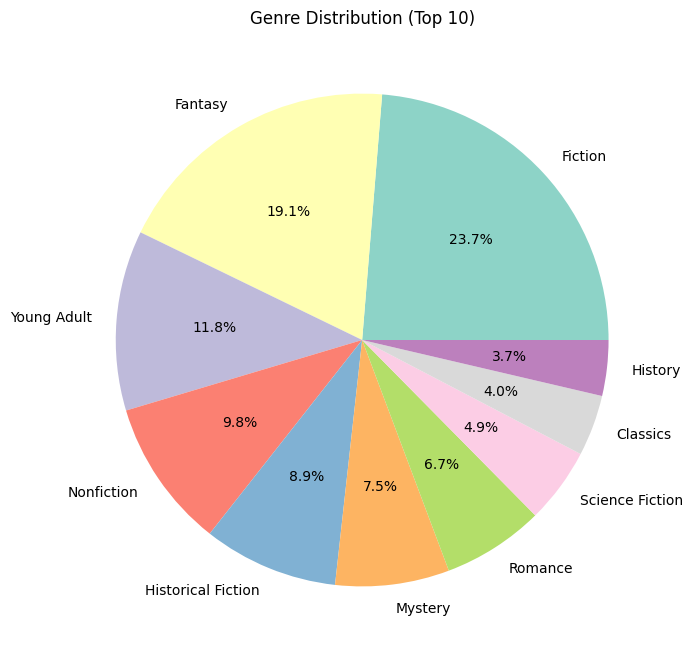

In [ ]:
# Step 5: Visualizations
# 1. Genre Distribution (Pie Chart)
plt.figure(figsize=(8, 8))
df['main_genre'].value_counts().head(10).plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title("Genre Distribution (Top 10)")
plt.ylabel("")
plt.show()



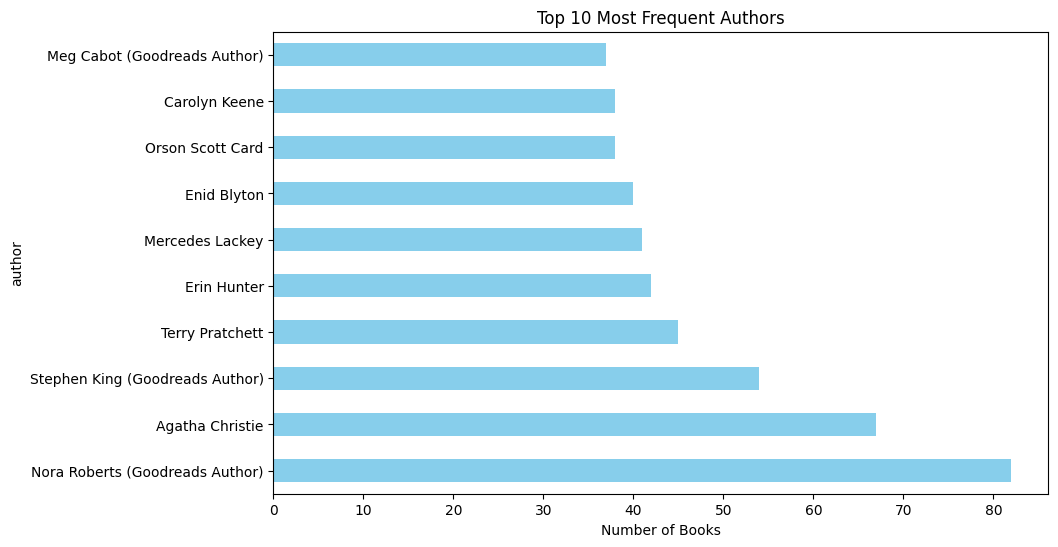

In [ ]:
# 2. Top 10 Authors (Horizontal Bar Plot)
plt.figure(figsize=(10, 6))
df['author'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Frequent Authors')
plt.xlabel('Number of Books')
plt.show()



<ipython-input-28-5597ce76e516>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




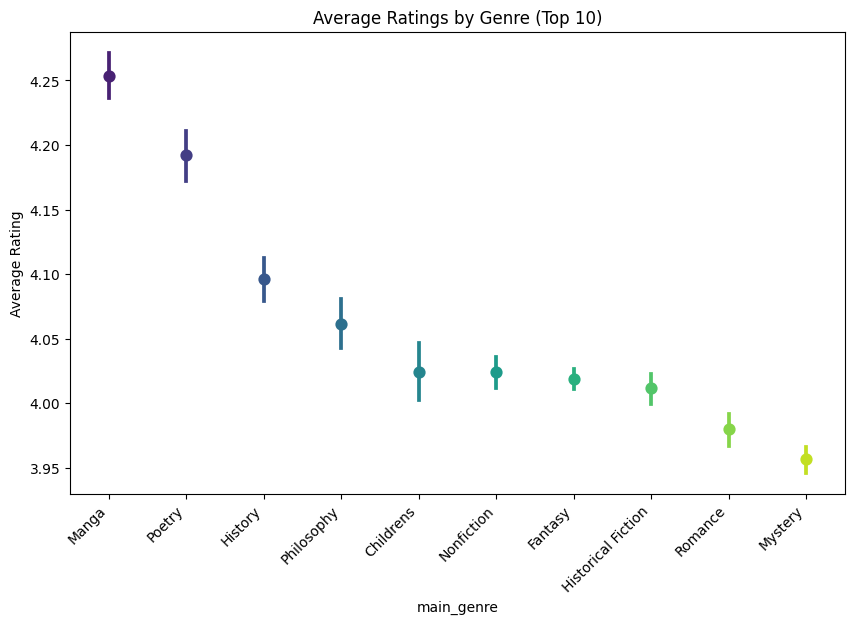

In [ ]:
# 3. Average Rating by Genre (Point Plot)
top_n_genres = 10
top_genres_avg_ratings = df.groupby('main_genre')['rating'].mean().nlargest(top_n_genres).index
plt.figure(figsize=(10, 6))
sns.pointplot(data=df[df['main_genre'].isin(top_genres_avg_ratings)],
               x='main_genre', y='rating', palette='viridis', order=top_genres_avg_ratings)
plt.title(f'Average Ratings by Genre (Top {top_n_genres})')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Rating')
plt.show()



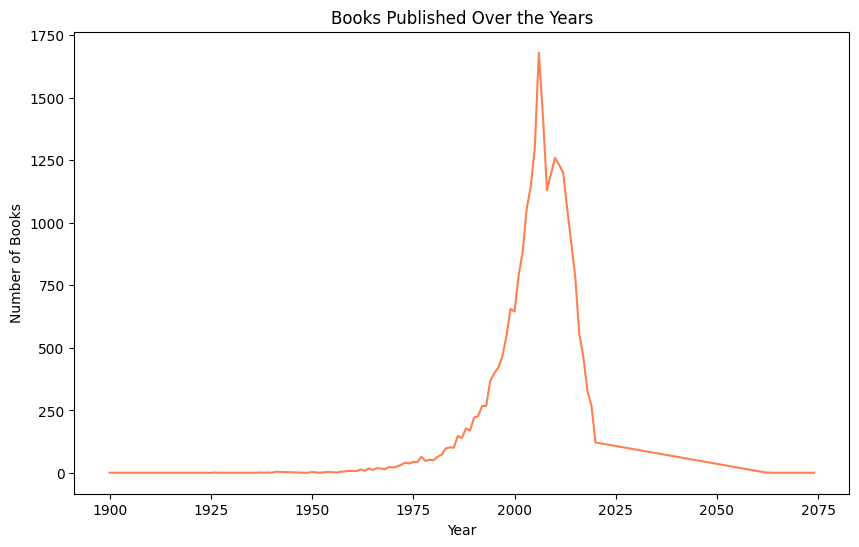

In [ ]:
# 4. Books Published Over the Years (Line Plot)
plt.figure(figsize=(10, 6))
df['publishYear'].value_counts().sort_index().plot(kind='line', color='coral')
plt.title('Books Published Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.show()



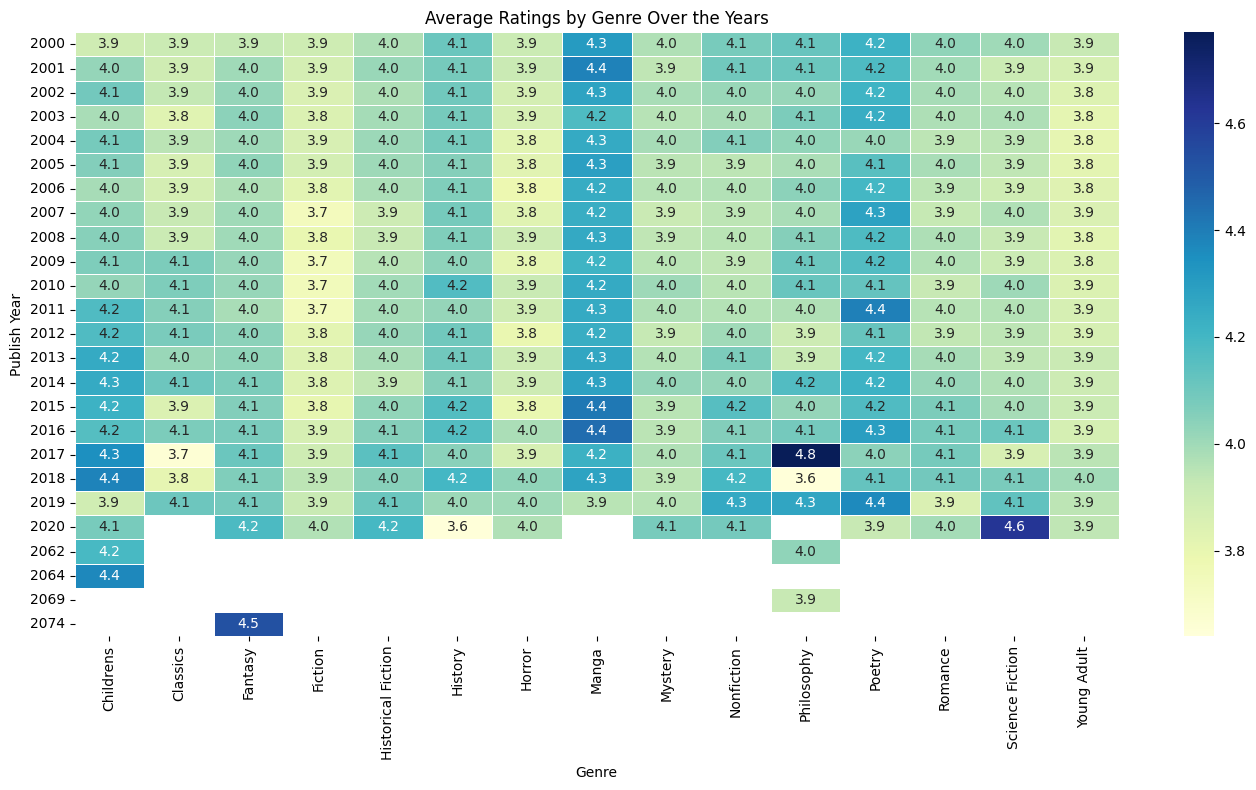

In [ ]:
# 5. Heatmap - Average Ratings by Genre & Year
heatmap_data = df.groupby(['publishYear', 'main_genre'])['rating'].mean().unstack()
heatmap_data = heatmap_data.loc[heatmap_data.index >= 2000]
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5)
plt.title('Average Ratings by Genre Over the Years')
plt.xlabel('Genre')
plt.ylabel('Publish Year')
plt.tight_layout()
plt.show()



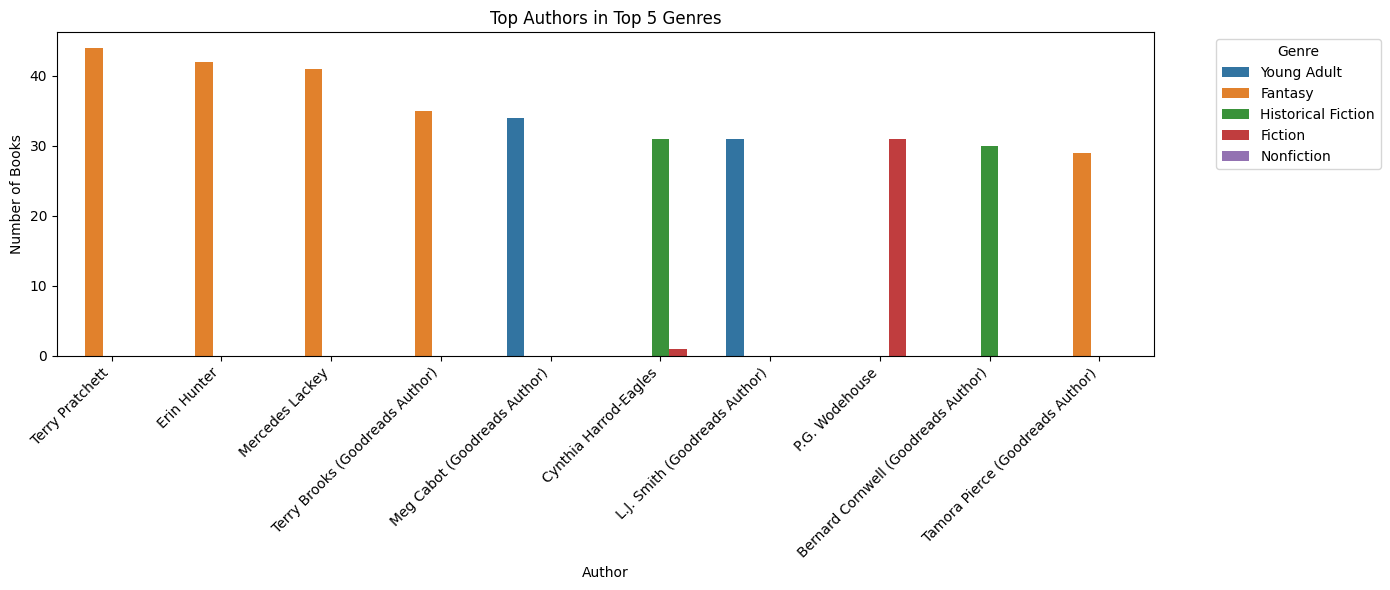

In [ ]:
# 6. Top Authors in Top 5 Genres
top_5_genres = df['main_genre'].value_counts().nlargest(5).index
filtered_df = df[df['main_genre'].isin(top_5_genres)]
plt.figure(figsize=(14, 6))
sns.countplot(data=filtered_df, x='author', hue='main_genre', order=filtered_df['author'].value_counts().head(10).index)
plt.title('Top Authors in Top 5 Genres')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



<ipython-input-32-3eca7bc8dc87>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




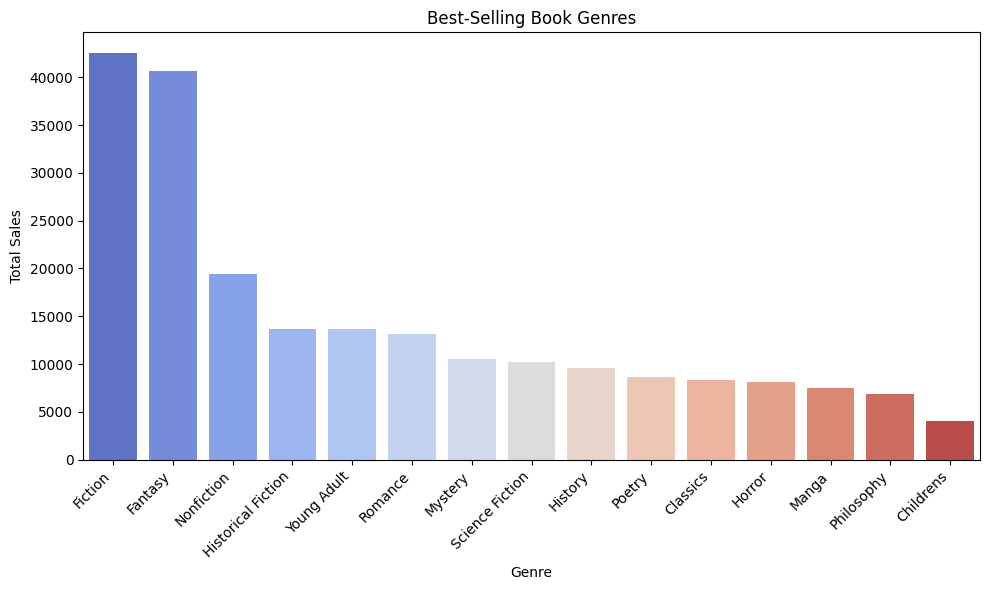

In [ ]:
# 7. Best-Selling Book Genres
genre_sales = df.groupby('main_genre')['price'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=genre_sales.index, y=genre_sales.values, palette='coolwarm')
plt.title('Best-Selling Book Genres')
plt.xlabel('Genre')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



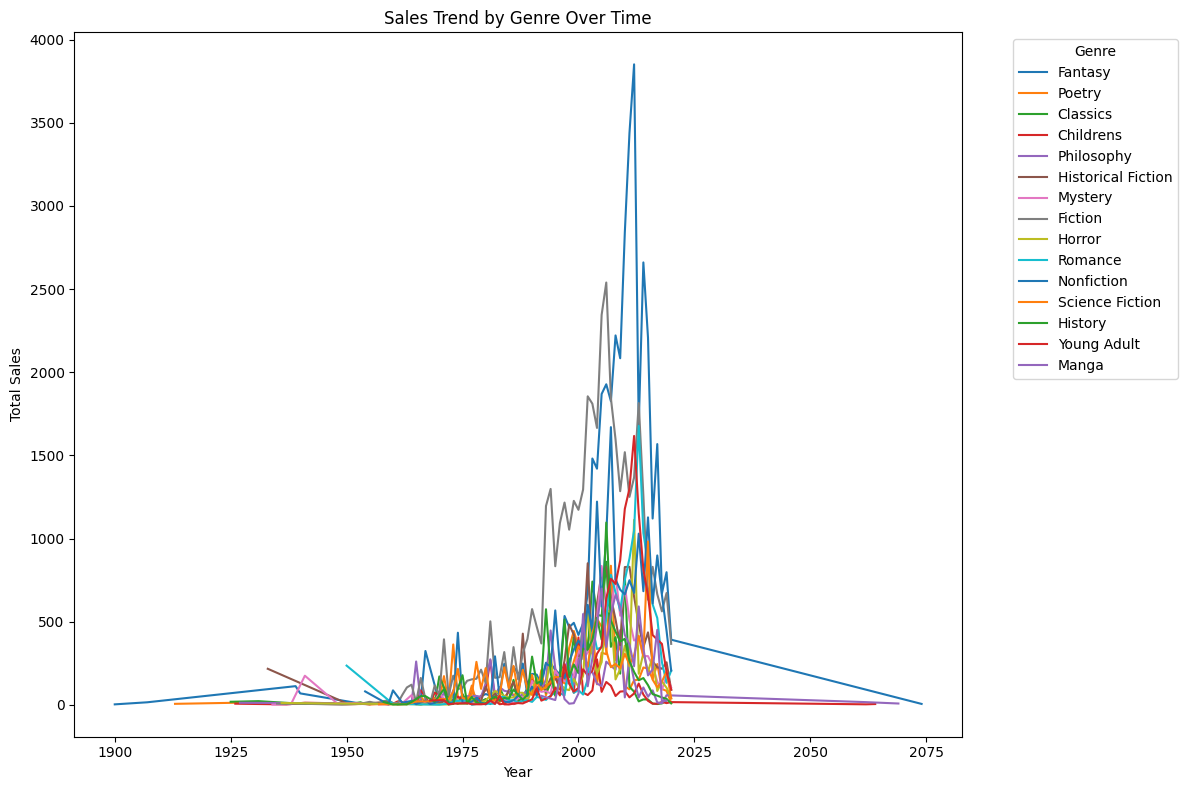

In [ ]:
# 8. Sales Trend by Genre Over Time
sales_trend = df.groupby(['publishYear', 'main_genre'])['price'].sum().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(data=sales_trend, x='publishYear', y='price', hue='main_genre', palette='tab10')
plt.title('Sales Trend by Genre Over Time')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
# 9. Popular Genres Over the Years (Animated Bar Chart)
genre_counts_over_time = df.groupby(['publishYear', 'main_genre'])['title'].count().reset_index()
fig = px.bar(genre_counts_over_time, x='main_genre', y='title', color='main_genre',
             animation_frame='publishYear', title='Popular Genres Over the Years (Animated)')
fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()